# Data and Predictions Visualizations

In [1]:
# standard libs
import json, os, shutil, wget

# data and viz libs
import numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import folium

In [2]:
# custom classes / functions
from ML.lstm_torch import LSTM_data_loader, LSTM_Predictor, train_lstm, predict_future

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("husl", 8))

rcParams['figure.figsize'] = 16, 12
register_matplotlib_converters()

## Data Setup

We're pulling our data from JHU COVID-19 data repo. The researchers update this data every day, so we remove and download everyday. This downloads the csv with the most data points -- which is very useful due to how generally sparse this data is. This loses state-level information after 3/22, so we use a snap shot for modeling at state level information

If you are just interested in using using country-level information, certainly go ahead and use the most recent iteration of `time_series_covid19_confirmed_global.csv` for models that generally converge with less parameter tuning.

In [6]:
if os.path.isfile('time_series_covid19_confirmed_global.csv'):
    os.remove('time_series_covid19_confirmed_global.csv')
    
wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

'time_series_covid19_confirmed_global.csv'

In [7]:
#read in our 3/22 snap shot
confirmed = pd.read_csv('./data/jhu_data/time_series_19-covid-Confirmed_3_22.csv')

In [8]:
confirmed.drop(columns=['Unnamed: 0'], inplace=True)
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,701,773,839,825,878,889,924,963,1007,1086
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,200,212,226,243,266,313,345,385,432,455
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,197,238,428,566,673,790,900,1030,1183,1306


In [9]:
dates = confirmed.columns[4:]
ndays = len(dates)

Here we melt our data out of the time-series panel-data style and transform it vertically, stacking the dates on top of each other. This is necessary for feeding our data into our visualization tools.

In [10]:
confirmed_melted = confirmed.melt(id_vars=['Province/State', 
                                         'Country/Region', 
                                         'Lat', 
                                         'Long'], 
                                value_vars=dates, 
                                var_name='Date', 
                                value_name='Confirmed')

Set our first and last date for masking our dataframes.

In [11]:
#only keep unique dates 
date_list = confirmed_melted['Date'].tolist()
date_list = list(dict.fromkeys(date_list))

In [12]:
first_day = date_list[0]
second_day = date_list[1]
second_to_last_day = date_list[-2]
last_day = date_list[-1]

In [13]:
last_day

'3/22/20'

We read in our json with all of our nation-level lat-long data for mapping.

In [14]:
countries_geo = './data/geo_data/world-countries.json'

# load in the json
with open(countries_geo, 'r') as f:
    wc = json.load(f)

# pull out the names aligned with the lat long data in the json
country_features = [x['properties']['name'] for x in wc['features']]

# pull the names used by the jhu dataset
country_names = confirmed_melted['Country/Region'].tolist()
country_names[0]

'Thailand'

This helper function gives us the misaligned names between the dataset and the lat-long data. We're looking for any big-ticket countries that we know we want to map and can do an easy brute-force fix by switching the names with pandas commands

In [15]:
def find_missing_countries(features_list, names_list):
    out_list = []
    for n in names_list:
        if n not in features_list:
            out_list.append(n)
    
    return out_list

Just with a quick scan, we can see the US and South Korea don't have their names aligned correctly, but that's an easy fix using an `np.where`.

In [16]:
missing = find_missing_countries(country_features, country_names)

# get rid of any duplicates in our list
missing = list(dict.fromkeys(missing))
print(missing)

['Singapore', 'Bahrain', 'North Macedonia', 'San Marino', 'Monaco', 'Andorra', 'Liechtenstein', 'Serbia', 'Malta', 'Martinique', 'Maldives', 'US', 'Holy See', 'Korea, South', 'Cruise Ship', 'Czechia', 'Taiwan*', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Antigua and Barbuda', 'Seychelles', 'Eswatini', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Congo (Brazzaville)', 'Tanzania', 'Barbados', 'Mauritius', 'Gambia, The', 'Bahamas, The', 'Cabo Verde', 'Cape Verde', 'Dominica', 'Grenada', 'Timor-Leste', 'Guadeloupe', 'Reunion', 'French Guiana', 'Mayotte', 'Guam', 'Guernsey', 'Jersey', 'The Gambia']


## First Day Nation-Level Confirmation

The first step we take is to strip out all rows that aren't the first date in our data  set (1/22/20).

In [17]:
mask1 = confirmed_melted['Date'].str.contains(first_day)
first_day_df = confirmed_melted[mask1]
first_day_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Thailand,15.0000,101.0000,1/22/20,2
1,NaN,Japan,36.0000,138.0000,1/22/20,2
2,NaN,Singapore,1.2833,103.8333,1/22/20,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0


Force the the US and South Korea naming fix.

In [18]:
first_day_df['Country/Region'] = np.where(first_day_df['Country/Region'] == 'US', 
                                          'United States of America', 
                                          first_day_df['Country/Region'])

first_day_df['Country/Region'] = np.where(first_day_df['Country/Region'] == 'Korea, South', 
                                          'South Korea', 
                                          first_day_df['Country/Region'])

Save out lat-long data form the jhu data set for later merging after some quick aggregation functions.

In [19]:
lat_long_save = first_day_df[['Country/Region', 'Lat', 'Long']]

Aggregating the cases over the regions and merge back with lat-long data.

In [20]:
first_day_df = first_day_df[['Country/Region', 'Confirmed']]
first_day_df = first_day_df.groupby('Country/Region').sum().reset_index()
first_day_df = pd.merge(left=first_day_df, right=lat_long_save, on='Country/Region')

Create our folium map object. The interpretation is pretty simple -- China has the vast majority of confirmed cases while most other countries have very few.

In [21]:
countries_geo = './data/geo_data/world-countries.json'

m = folium.Map(location=[20, 20], zoom_start=2)

bins = [0, 10, 100, 1000]

folium.Choropleth(
    geo_data=countries_geo,
    name='World Confirmed Cases 1/22',
    data=first_day_df,
    columns=['Country/Region', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Confirmed Cases',
    highlight=True
).add_to(m)

folium.LayerControl().add_to(m)

m

In [22]:
m.save('./outputs/map_html/first_day_confirmed_cases.html')

As we can see, outside of China, there are very few confirmed cases (7 total) with the one confirmed in the US being the only one outside of Eastern Asia.

In [23]:
first_day_df = first_day_df[['Country/Region', 'Confirmed']]
first_day_df.drop_duplicates(inplace=True)
first_day_df.sort_values(by='Confirmed',ascending=False).head(10)

,Country/Region,Confirmed
52,China,548
149,Japan,2
228,Thailand,2
218,South Korea,1
226,Taiwan*,1
246,United States of America,1
0,Afghanistan,0
187,Nigeria,0
178,Namibia,0
179,Nepal,0


## Last Day Nation-Level Confirmation

We then repeat the process, but for the last day provided in the data set.

In [24]:
mask1 = confirmed_melted['Date'].str.contains(last_day)
last_day_df = confirmed_melted[mask1]
last_day_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
30060,NaN,Thailand,15.0000,101.0000,3/22/20,599
30061,NaN,Japan,36.0000,138.0000,3/22/20,1086
30062,NaN,Singapore,1.2833,103.8333,3/22/20,455
30063,NaN,Nepal,28.1667,84.2500,3/22/20,2
30064,NaN,Malaysia,2.5000,112.5000,3/22/20,1306


In [25]:
# Force fix for US / South Korea
last_day_df['Country/Region'] = np.where(last_day_df['Country/Region'] == 'US', 
                                          'United States of America', 
                                          last_day_df['Country/Region'])

last_day_df['Country/Region'] = np.where(last_day_df['Country/Region'] == 'Korea, South', 
                                          'South Korea', 
                                          last_day_df['Country/Region'])

# Saving out lat-long info
lat_long_save = last_day_df[['Country/Region', 'Lat', 'Long']]

# Aggregate and bring the lat-long information back in
last_day_df = last_day_df[['Country/Region', 'Confirmed']]
last_day_df = last_day_df.groupby('Country/Region').sum().reset_index()
last_day_df = pd.merge(left=last_day_df, right=lat_long_save, on='Country/Region')
last_day_df.head()

,Country/Region,Confirmed,Lat,Long
0,Afghanistan,40,33.0000,65.0000
1,Albania,89,41.1533,20.1683
2,Algeria,201,28.0339,1.6596
3,Andorra,113,42.5063,1.5218
4,Angola,2,-11.2027,17.8739


In this map, we use basic quantile bins as the spread is much more dispersed among nations. In this map, we use the lat-long info for regions, states, and in some situations cities for where there are registered cases (if you hover, it will show you nation-level confirmed-cases). Per the visualization, a vast majority of confirmed cases are still in China; however, some western countries like Italy, Spain, and the US are experiencing rapid increases in case confirmations. Other than the shading corresponding to generally how many cases are within the country, the black dots on the graph illustrate a coordinate (sometimes just dropped at the center of a country or region) where there are more than 20 confirmed cases.

In [26]:
countries_geo = './data/geo_data/world-countries.json'

m = folium.Map(location=[20, 20], zoom_start=2)

folium.Choropleth(
    geo_data=countries_geo,
    name='choropleth',
    data=last_day_df,
    columns=['Country/Region', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=5,
    legend_name='Confirmed Cases',
    highlight=True
).add_to(m)

for lat, lon, val, country in zip(last_day_df['Lat'], last_day_df['Long'],last_day_df['Confirmed'], last_day_df['Country/Region']):
    if val > 20:
        folium.CircleMarker([lat, lon],
                            radius=1,
                            color='black',
                            tooltip =(country + ': ' + str(val)),
                            fill_opacity=0.9 ).add_to(m)

folium.LayerControl().add_to(m)

m

In [27]:
m.save('./outputs/map_html/last_day_confirmed_cases.html')

While covid-19 reached pandemic status over much earlier in March, these statistics showing nations in three continents with confirmed cases over 5,000.

In [28]:
last_day_df_counts = last_day_df[['Country/Region', 'Confirmed']].copy()
last_day_df_counts.drop_duplicates(inplace=True)
last_day_df_counts.sort_values(by='Confirmed',ascending=False).head(10)

,Country/Region,Confirmed
52,China,81397
147,Italy,59138
246,United States of America,33272
219,Spain,28768
125,Germany,24873
143,Iran,21638
112,France,16176
218,South Korea,8897
224,Switzerland,7245
239,United Kingdom,5741


While a bit of busy kernel density estimation, this does give us a good visual representation of where these most countries are in terms of their covid epedemics. We have a cluster of countries that have relatively few confirmed cases, and a cluster that are between 20 and 40 thousand.

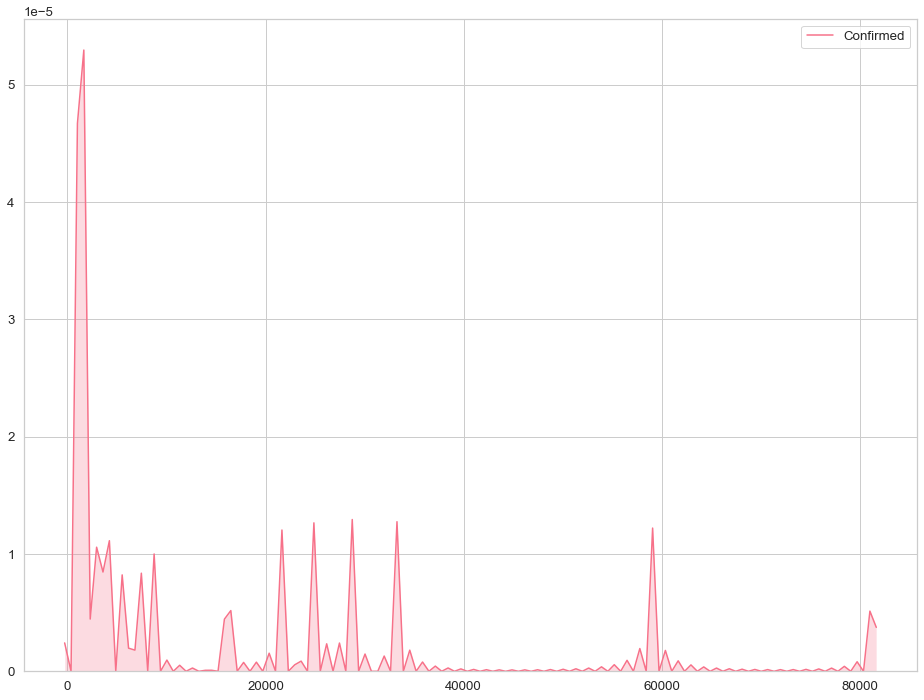

In [29]:
sns.kdeplot(last_day_df_counts['Confirmed'], cbar=True, shade=True)

## Model Predictions

Using the predictor and data loader / transforming in the macro-predictions notebook, we generated a sequence of time-series predictions using LSTM (Lon Short-Term Memory) neural networks. While the amount of data is still relatively sparse, our models did typically converge (some better than others). These are naive models, meaning that each country was trained on its own data in a closed system, but it's still interesting to see the results mapped out. We follow a similar process as we did for the other first and last days of the jhu data, but in this situation, we take the last day of the predicted sequence (10 days later) and map that as the prediction of confirmed cases. Note that in cases where models did not converge (i.e. out training algorithms didn't find statistically meaningful relationships in the growth data), the predicted value may appear to just be a leveling off or even a slight decrease in the previously reported amount of confirmed cases.

In [30]:
# load in and evaluate our data
with open('country_predictions_nodelta.json', 'r') as fp:
    prediction_data = json.load(fp)
    
prediction_data = eval(prediction_data)

In [31]:
# cleaning our json data and passing it into a data frame
for country in prediction_data.keys():
    prediction_data[country] = np.array(prediction_data[country])
    
predictions_df = pd.DataFrame(columns=['Country/Region', 'Confirmed'])

for country in prediction_data.keys():
    predictions_df = predictions_df.append(
                                {'Country/Region': country, 
                                 'Confirmed' : int(round(prediction_data[country][-1],0))},
                                ignore_index=True)
    
# par for the course, brute force a quick fix
predictions_df['Country/Region'] = np.where(predictions_df['Country/Region'] == 'US', 
                                          'United States of America', 
                                          predictions_df['Country/Region'])

predictions_df['Country/Region'] = np.where(predictions_df['Country/Region'] == 'Korea, South', 
                                          'South Korea', 
                                          predictions_df['Country/Region'])

# get our lat-long data for mapping specific confirmed locations
pdf_merge = last_day_df[['Country/Region', 'Lat', 'Long']]
predictions_df = pd.merge(left=predictions_df, right=pdf_merge,on='Country/Region')

Unsuprisingly, the nations at the top of our list look similar to those at the top of the other list, with the noteable difference of China dropping further down as they have curved their spike, while major western nations, per the LSTM models, have continued on their logarithmic-esque trajectory. See the demo notebook for some growth plots.

In [32]:
predictions_df_counts = predictions_df[['Country/Region','Confirmed']]
predictions_df_counts.drop_duplicates(inplace=True)
predictions_df_counts.sort_values(by='Confirmed',ascending=False).head(10)

,Country/Region,Confirmed
33,Italy,102207
107,United States of America,76140
35,Spain,72892
28,Germany,55541
360,China,54388
393,Iran,40575
395,France,34938
46,Switzerland,15752
415,United Kingdom,11259
394,South Korea,8541


In [33]:
countries_geo = './data/geo_data/world-countries.json'

m = folium.Map(location=[20, 20], zoom_start=2)

folium.Choropleth(
    geo_data=countries_geo,
    name='choropleth',
    data=predictions_df,
    columns=['Country/Region', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=5,
    legend_name='Confirmed Cases',
    highlight=True
).add_to(m)

for lat, lon, val, country in zip(predictions_df['Lat'], predictions_df['Long'],predictions_df['Confirmed'], predictions_df['Country/Region']):
    if val > 20:
        folium.CircleMarker([lat, lon],
                            radius=1,
                            color='black',
                            tooltip =(country + ': '+  str(val)),
                            fill_opacity=0.9 ).add_to(m)

folium.LayerControl().add_to(m)

m

In [34]:
m.save('./outputs/map_html/10_day_world.html')

Again, this kde plot doesn't give us too much other than showing where the density of country-level case are at this predicted point int time.

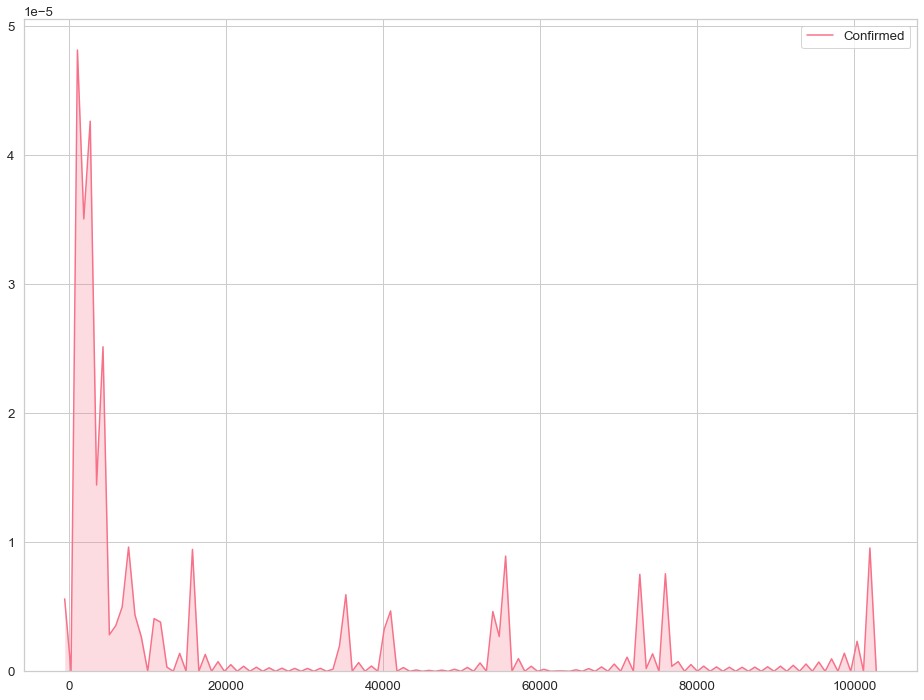

In [35]:
sns.kdeplot(predictions_df_counts['Confirmed'], cbar=True, shade=True)

## US States - First Day - New Daily Cases

Lets take a bit of a deep dive into a individual US States, but instead of confirmations, let's took at the amount of new daily cases. In some situations, fitting these LSTM networks for these growth curves was a bit more difficult and they typically had higher error (loss) estimations. This information does allow for more directional momentum though, as it makes much more intuitive sense for there to be dips below previous estimates. Logiclally speaking, total confirmed cases should not dip below its previous values, though sometimes the LSTM would if it could not converge.

In [36]:
#load in our state data
with open('./data/geo_data/us-states.json', 'r') as f:
    us_states = json.load(f)

# get the state abbreviations we need for plotting
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

In [37]:
# create our mapping that we use to clean the stae-elev info and aggreagte by states
state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

In [38]:
def remap_to_abr(name, mapping_dict):
    return mapping_dict[name]

In [39]:
mask1 = confirmed_melted['Date'].str.contains(first_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]

mask3 = confirmed_melted['Date'].str.contains(second_day)
mask4 = confirmed_melted['Country/Region'].str.contains('US')
second_day_df_US = confirmed_melted[mask3 & mask4]

Finding our new cases on a multi-region level is slightly more involved than doing it for a 1 dimensional vector like we do in our LSTM data loader. If you're a stickler for effective code, look away as we use two expensive for loops just to merge two very similar dataframes back together!

In [40]:
first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        
for x in state_abrs:
    counter=0
    for r in second_day_df_US['Province/State']:
        if x in r:
            second_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            second_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        
first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
second_day_df_US = second_day_df_US.groupby('Province/State').sum().reset_index()

diff_df = pd.merge(left=first_day_df_US, right=second_day_df_US, on='Province/State')
diff_df['New_Cases'] = diff_df.apply(lambda row: row.Confirmed_x - row.Confirmed_y, axis=1)

Our map is pretty uneventful, as even though there is a confirmed case in Washington at the time, there is no change form the first to the last day... so we're not really showing anything here, except that the spread has not yet began. This is acts as a solid visual baseline, though, as it does pick up.

In [41]:
states_geo = './data/geo_data/us-states.json'

bins = [0, 10, 100, 1000, 10000]

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=states_geo,
    name='choropleth',
    data=diff_df,
    columns=['Province/State', 'New_Cases'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    highlight=True,
    legend_name='New Daily Cases'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [42]:
m.save('./outputs/map_html/first_day_new_cases_states.html')

## US States - Last Day - New Daily Cases

Here, we simple repeat the analysis, but for the second to last day and the last day as opposed to the second day and the first day.

In [43]:
mask1 = confirmed_melted['Date'].str.contains(last_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
last_day_df_US = confirmed_melted[mask1 & mask2]

mask3 = confirmed_melted['Date'].str.contains(second_to_last_day)
mask4 = confirmed_melted['Country/Region'].str.contains('US')
second_to_last_day_df_US = confirmed_melted[mask3 & mask4]

On the last day in this March 22nd sample, we can see that New York has the most case, by about a factor of 8.

In [44]:
last_day_df_US.sort_values(by='Confirmed', ascending=False).head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
30159,New York,US,42.1657,-74.9481,3/22/20,15793
30158,Washington,US,47.4009,-121.4905,3/22/20,1996
30167,New Jersey,US,40.2989,-74.5210,3/22/20,1914
30160,California,US,36.1162,-119.6816,3/22/20,1642
30170,Illinois,US,40.3495,-88.9861,3/22/20,1049


In [45]:
second_to_last_day_df_US.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
29657,Washington,US,47.4009,-121.4905,3/21/20,1793
29658,New York,US,42.1657,-74.9481,3/21/20,11710
29659,California,US,36.1162,-119.6816,3/21/20,1364
29660,Massachusetts,US,42.2302,-71.5301,3/21/20,525
29661,Diamond Princess,US,35.4437,139.6380,3/21/20,49


Below we're just doing the same masking and state aggregation analysis as we do above.

In [46]:
mask1 = confirmed_melted['Date'].str.contains(last_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
last_day_df_US = confirmed_melted[mask1 & mask2]

mask3 = confirmed_melted['Date'].str.contains(second_to_last_day)
mask4 = confirmed_melted['Country/Region'].str.contains('US')
second_to_last_day_df_US = confirmed_melted[mask3 & mask4]


for x in state_abrs:
    counter=0
    for r in last_day_df_US['Province/State']:
        if x in r:
            last_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            last_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        
for x in state_abrs:
    counter=0
    for r in second_to_last_day_df_US['Province/State']:
        if x in r:
            second_to_last_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            second_to_last_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        
lat_long_save = last_day_df_US[['Province/State', 'Lat', 'Long']]
last_day_df_US = last_day_df_US[['Province/State','Confirmed']]
last_day_df_US = last_day_df_US.groupby('Province/State').sum().reset_index()
second_to_last_day_df_US = second_to_last_day_df_US[['Province/State','Confirmed']]
second_to_last_day_df_US = second_to_last_day_df_US.groupby('Province/State').sum().reset_index()

last_diff = pd.merge(left=last_day_df_US, right=second_to_last_day_df_US, on = 'Province/State')
last_diff['New_Cases'] = last_diff.apply(lambda row: row.Confirmed_x - row.Confirmed_y, axis=1)
last_diff = last_diff[['Province/State', 'New_Cases']]
last_diff = pd.merge(left=last_diff, right=lat_long_save, on='Province/State')

In this map we can see the most affected areas in terms of daily new cases are generally the eastern part of the country, particularly the North East, the West Coast, and Colorado. The black dots correspond to anywhere there is confirmed case.

In [47]:
states_geo = './data/geo_data/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

bins = [0, 50, 100, 1000, 5000]

folium.Choropleth(
    geo_data=states_geo,
    name='choropleth',
    data=last_diff,
    columns=['Province/State', 'New_Cases'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    highlight=True,
    legend_name='New Cases'
).add_to(m)

for lat, lon, val, state in zip(last_diff['Lat'], last_diff['Long'],last_diff['New_Cases'], last_diff['Province/State']):
    if val:
        folium.CircleMarker([lat, lon],
                            radius=1,
                            color='black',
                            tooltip =(state + ': '+  str(val)),
                            fill_opacity=0.9 ).add_to(m)

folium.LayerControl().add_to(m)

m

In [48]:
m.save('./outputs/map_html/last_day_new_cases_states.html')

## US States - Last Day - New Daily Cases - 10 Day Predictions

In this set of predictions, we trained the LSTM on the data from individual states (as opposed to countries in the other set of predictions), and it's trained to predict the number of new cases, as opposed to total confirmed cases.

In [49]:
with open('state_predictions_delta.json', 'r') as fp:
    daily_case_preds = json.load(fp)
    
daily_case_preds = eval(daily_case_preds)

# cleaning our json data and passing it into a data frame
for state in daily_case_preds.keys():
    daily_case_preds[state] = np.array(daily_case_preds[state])
    
predict_daily_cases_df = pd.DataFrame(columns=['Province/State', 'Confirmed'])

for state in daily_case_preds.keys():
    predict_daily_cases_df = predict_daily_cases_df.append(
                                {'Province/State': state, 
                                 'New_Cases' : int(round(daily_case_preds[state][-1],0))},
                                ignore_index=True)

Below were just merging our predictions with the geo-spatial data from the last day to show where there have been confirmed cases previously.

In terms of the amount of new daily cases we're seeing, our LSTM model for New predicts incredibly high daily growth, more than 10x that of the what it thinks will be the second fastest growing (Texas). Generally speaking, it seems as though New York is expected to continue rapidly growing, while Texas and Michigan, per the LSTM predictions, are expected to become new hot beds.

I would like to make the point to stress again that this is simply an exercise in predictive analytics on time-series data using deep learning. This is not not an epidemiological study on the real the growth and dispersion of covid-19. There are many more accurate and tested ways to determine real growth.

In [50]:
predict_daily_cases_df = pd.merge(left=predict_daily_cases_df, right = last_diff, on='Province/State')
predict_daily_cases_df = predict_daily_cases_df[['Province/State','New_Cases_x','Lat','Long']]
predict_daily_cases_df.rename(columns={'New_Cases_x' : 'New_Cases'},inplace=True)
# predict_daily_cases_df.head()
predict_daily_cases_df_counts = predict_daily_cases_df[['Province/State', 'New_Cases']]
predict_daily_cases_df_counts.drop_duplicates(inplace=True)
predict_daily_cases_df_counts.sort_values(by='New_Cases', ascending=False).head(10)

,Province/State,New_Cases
147,NY,21106.0
201,TX,1533.0
114,MI,1176.0
49,FL,488.0
175,PA,462.0
63,GA,392.0
7,CA,385.0
2,AZ,312.0
222,WA,303.0
103,MD,258.0


In [51]:
states_geo = './data/geo_data/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

bins = [0, 50, 500, 5000, 25000]

folium.Choropleth(
    geo_data=states_geo,
    name='choropleth',
    data=predict_daily_cases_df,
    columns=['Province/State', 'New_Cases'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    highlight=True,
    legend_name='New Cases'
).add_to(m)

for lat, lon, val, state in zip(predict_daily_cases_df['Lat'], predict_daily_cases_df['Long'],predict_daily_cases_df['New_Cases'], predict_daily_cases_df['Province/State']):
    if val:
        folium.CircleMarker([lat, lon],
                            radius=1,
                            color='black',
                            tooltip =(state + ': '+  str(val)),
                            fill_opacity=0.9 ).add_to(m)

folium.LayerControl().add_to(m)

m

In [52]:
m.save('./outputs/map_html/10_day_new_cases_states.html')